In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam




In [2]:
time_window = 15
prediction_horizon = 10

In [3]:
df = pd.read_csv(r"CNNdata\fulldata.csv")
df["DateTime"] = pd.to_datetime(df["DateTime"])
df.set_index(df["DateTime"], inplace=True)
df = df.resample("500ms").mean()
df = df.fillna(method='ffill')  
df
del df["DateTime"]


Text(0.5, 1.0, 'Distribution of Log-Returns at Event-Time')

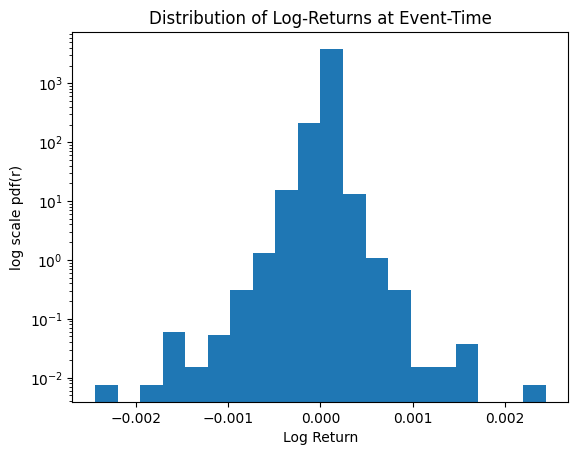

In [10]:
plt.hist(df["Returns"],density=True,bins=20)
plt.yscale("log")
plt.ylabel("log scale pdf(r)")
plt.xlabel("Log Return")
plt.title("Distribution of Log-Returns at Event-Time")

In [4]:
print(df.dtypes)
print(df.isnull().sum().cumsum())


Price                 float64
Mid                   float64
WAP                   float64
Returns               float64
Spread                float64
                       ...   
Is_3                    int64
Is_4                    int64
Is_5                    int64
Next_Mid_Direction    float64
Mid_Change            float64
Length: 71, dtype: object
Price                 0
Mid                   0
WAP                   0
Returns               0
Spread                0
                     ..
Is_3                  0
Is_4                  0
Is_5                  0
Next_Mid_Direction    0
Mid_Change            0
Length: 71, dtype: int64


In [5]:
for index in df:
    print(index,df[index].isna().sum())

Price 0
Mid 0
WAP 0
Returns 0
Spread 0
Delta_AP_1 0
Delta_BP_1 0
Size 0
Direction 0
MA5_Order_Direction 0
MA10_Order_Direction 0
MA15_Order_Direction 0
Ask_Price_Level_1 0
Ask_Volume_Level_1 0
Bid_Price_Level_1 0
Bid_Volume_Level_1 0
Ask_Price_Level_2 0
Ask_Volume_Level_2 0
Bid_Price_Level_2 0
Bid_Volume_Level_2 0
Ask_Price_Level_3 0
Ask_Volume_Level_3 0
Bid_Price_Level_3 0
Bid_Volume_Level_3 0
Ask_Price_Level_4 0
Ask_Volume_Level_4 0
Bid_Price_Level_4 0
Bid_Volume_Level_4 0
Ask_Price_Level_5 0
Ask_Volume_Level_5 0
Bid_Price_Level_5 0
Bid_Volume_Level_5 0
Ask_Price_Level_6 0
Ask_Volume_Level_6 0
Bid_Price_Level_6 0
Bid_Volume_Level_6 0
Ask_Price_Level_7 0
Ask_Volume_Level_7 0
Bid_Price_Level_7 0
Bid_Volume_Level_7 0
Ask_Price_Level_8 0
Ask_Volume_Level_8 0
Bid_Price_Level_8 0
Bid_Volume_Level_8 0
Ask_Price_Level_9 0
Ask_Volume_Level_9 0
Bid_Price_Level_9 0
Bid_Volume_Level_9 0
Ask_Price_Level_10 0
Ask_Volume_Level_10 0
Bid_Price_Level_10 0
Bid_Volume_Level_10 0
Ask_Volume 0
Bid_Volume 

In [6]:
def create_target(df, prediction_horizon=10):
    target = np.zeros(len(df) - prediction_horizon)  

    for i in range(len(df) - prediction_horizon):
      current_price = df['Mid'].iloc[i]
      future_price = df['Mid'].iloc[i + prediction_horizon]

      if future_price > current_price:
          target[i] = 2  
      elif future_price < current_price:
          target[i] = 0 
      else:
          target[i] = 1 

    return target



In [7]:
def create_image_data(X,time_window):
    num_samples = len(X) - time_window + 1
    num_channels = X.shape[1]
    images = np.zeros((num_samples,num_channels,time_window))
    for i in range(num_samples):
        images[i] = X[i:i+time_window].T
    return images

In [8]:


X = df.drop(["Next_Mid_Direction", "Mid_Change"], axis=1)  
X = X[:-prediction_horizon]

y = create_target(df, prediction_horizon) 

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

# Convert Size to float
X_train["Size"] = X_train["Size"].astype(np.float64)
X_val["Size"] = X_val["Size"].astype(np.float64)
X_test["Size"] = X_test["Size"].astype(np.float64)

numerical_cols = X_train.select_dtypes(include=np.float64).columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

X_train_images = create_image_data(X_train, time_window)
y_train_images = y_train[:len(X_train_images)] 

X_val_images = create_image_data(X_val, time_window)
y_val_images = y_val[:len(X_val_images)] 

X_test_images = create_image_data(X_test, time_window)
y_test_images = y_test[:len(X_test_images)] 

X_train.head()

,Price,Mid,WAP,Returns,Spread,Delta_AP_1,Delta_BP_1,Size,Direction,MA5_Order_Direction,...,vol_w10,vol_w15,MA_w5,MA_w10,MA_w15,Is_1,Is_2,Is_3,Is_4,Is_5
0,2.058802,2.372630,2.334073,0.001133,0.016691,0.000734,0.000903,-0.179508,1,0.050212,...,-0.603018,-0.710984,0.002768,0.004176,0.005342,1,0,0,0,0
1,2.302358,2.372630,2.332353,0.001133,0.016691,0.000734,0.000903,-0.480378,1,0.050212,...,-0.603018,-0.710984,0.002768,0.004176,0.005342,0,0,0,1,0
2,2.302358,2.372630,2.322315,0.001133,0.016691,0.000734,0.000903,0.759207,1,0.050212,...,-0.603018,-0.710984,0.002768,0.004176,0.005342,0,0,0,1,0
3,2.302358,2.370018,2.309486,-0.329728,0.108743,0.000734,-0.530167,1.986757,-1,0.050212,...,-0.603018,-0.710984,0.002768,0.004176,0.005342,0,0,0,0,1
4,2.058802,2.370018,2.309486,0.001133,0.108743,0.000734,0.000903,-0.179508,1,1.076333,...,-0.603018,-0.710984,-0.158962,0.004176,0.005342,0,0,1,0,0


In [9]:


def create_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),  

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  
        layers.BatchNormalization(), 
        layers.MaxPooling1D(pool_size=2), 

        layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),  
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2), 

        layers.Flatten(), 
        layers.Dense(128, activation='relu'),  
        layers.Dropout(0.5),  
        layers.Dense(3,activation="softmax") 
    ])
    return model




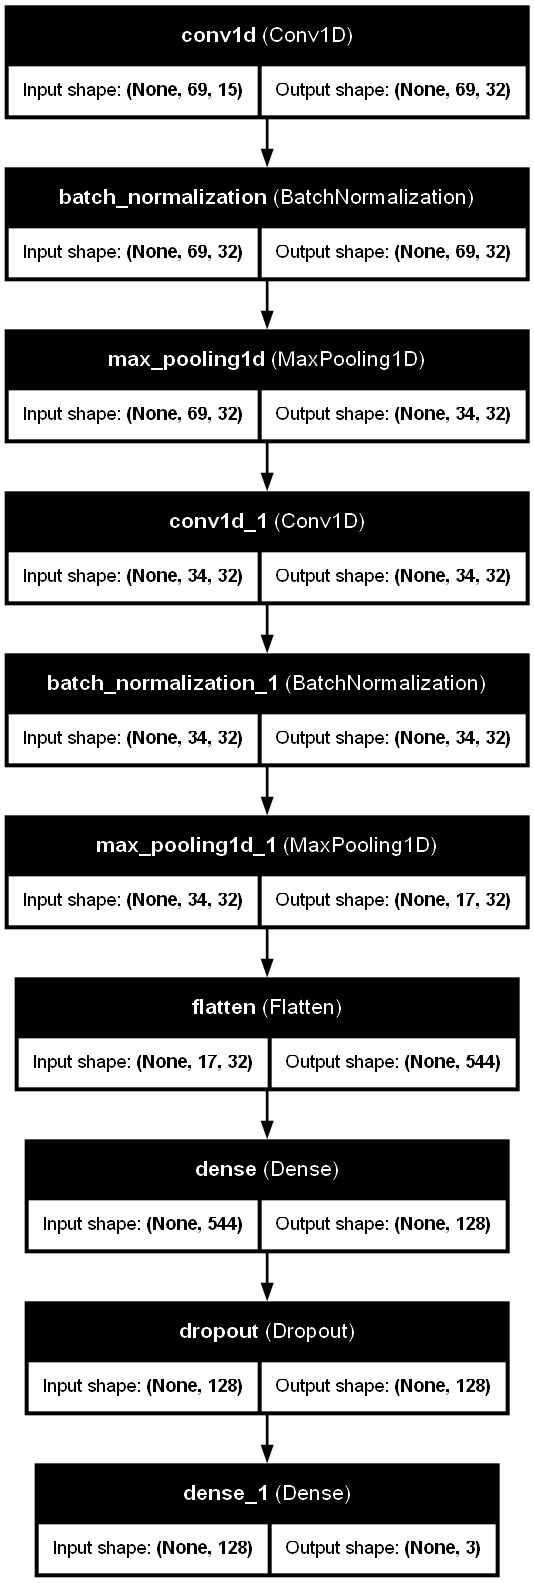

In [10]:


input_shape = (X_train_images.shape[1], X_train_images.shape[2])
model = create_model(input_shape)
learning_rate = 0.0001  
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

tf.keras.utils.plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True, dpi=96)





In [11]:
batch_size = 32
epochs = 5

history = model.fit(X_train_images, y_train_images, epochs=epochs, 
                batch_size=batch_size, validation_data=(X_val_images, y_val_images), verbose=1)



Epoch 1/5
11945/11945 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - accuracy: 0.5194 - loss: 1.0452 - val_accuracy: 0.4027 - val_loss: 1.1878
Epoch 2/5
11945/11945 ━━━━━━━━━━━━━━━━━━━━ 64s 5ms/step - accuracy: 0.6598 - loss: 0.7868 - val_accuracy: 0.2963 - val_loss: 2.3266
Epoch 3/5
11945/11945 ━━━━━━━━━━━━━━━━━━━━ 71s 6ms/step - accuracy: 0.8199 - loss: 0.4574 - val_accuracy: 0.4882 - val_loss: 1.0873
Epoch 4/5
11945/11945 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.8795 - loss: 0.3132 - val_accuracy: 0.7219 - val_loss: 0.6956
Epoch 5/5
11945/11945 ━━━━━━━━━━━━━━━━━━━━ 65s 5ms/step - accuracy: 0.9130 - loss: 0.2328 - val_accuracy: 0.7303 - val_loss: 0.6866


In [14]:
print(len(y_train[y_train==2])/len(y_train),len(y_train[y_train==2])," Up")
print(len(y_train[y_train==0])/len(y_train),len(y_train[y_train==0]),"Down")
print(len(y_train[y_train==1])/len(y_train),len(y_train[y_train==1]),"Neutral")
print(len(y_train),"Training Size\n")

print(len(y_test_images[y_test_images==2])/len(y_test_images),len(y_test_images[y_test_images==2])," Up")
print(len(y_test_images[y_test_images==0])/len(y_test_images),len(y_test_images[y_test_images==0])," Down")
print(len(y_test_images[y_test_images==1])/len(y_test_images),len(y_test_images[y_test_images==1])," Neutral")
print(len(y_test_images),"Testing Size")

print("\n",len(y_test_images)/len(y_train_images))

0.2664592958461305 101853  Up
0.26108840903501934 99800 Down
0.4724522951188502 180593 Neutral
382246 Training Size

0.2588617409673126 21200  Up
0.26631012124986264 21810  Down
0.4748281377828248 38887  Neutral
81897 Testing Size

 0.2142599259088721


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test Accuracy (using predictions): 0.7637642404483681
              precision    recall  f1-score   support

           0       0.63      1.00      0.77     21810
           1       0.81      0.74      0.78     38887
           2       0.99      0.57      0.72     21200

    accuracy                           0.76     81897
   macro avg       0.81      0.77      0.76     81897
weighted avg       0.81      0.76      0.76     81897

[[21726    69    15]
 [10027 28786    74]
 [ 2636  6526 12038]]
Test Accuracy (using model.evaluate): 0.7637642621994019


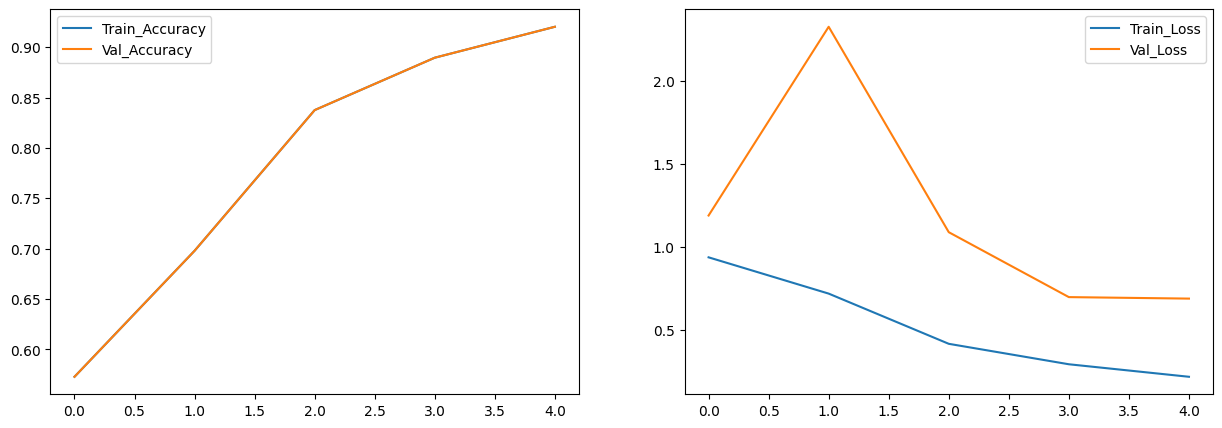

In [15]:
predictions = model.predict(X_test_images)
predicted_labels = np.argmax(predictions, axis=1) 
accuracy = accuracy_score(y_test_images.astype(int), predicted_labels)
print(f"Test Accuracy (using predictions): {accuracy}")

print(classification_report(y_test_images.astype(int),predicted_labels))

print(confusion_matrix(y_test_images.astype(int),predicted_labels))

loss, accuracy_eval = model.evaluate(X_test_images, y_test_images, verbose=0)
print(f"Test Accuracy (using model.evaluate): {accuracy_eval}")

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(history.history["accuracy"],label="Train_Accuracy")
ax[0].plot(history.history["accuracy"],label="Val_Accuracy")
ax[1].plot(history.history["loss"],label="Train_Loss")
ax[1].plot(history.history["val_loss"],label="Val_Loss")
ax[0].legend()
ax[1].legend()
